# Temperature Prediction

## Project Overview

Due to the global warming, we're facing so many challenges but still we've taken very little steps to reduce it. This project tries to show what is the effects of global warming in a City of Bangladesh (Pabna) which had quite reasonable weather. But now, we're facing many serious problems like heart diseases, heat stroke and other respiratory problems because of rising average temparature.

## Data Exploration

### Data loading and initial exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/train.csv', index_col='DATE')
df.index = pd.to_datetime(df.index)
df.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN
DATE,,,,,,,,,
2000-01-01,BGM00041907,"ISHURDI, BG",24.153,89.049,13.7,0.0,61,75.0,NaN
2000-01-07,BGM00041907,"ISHURDI, BG",24.153,89.049,13.7,0.0,54,68.0,NaN
2000-01-08,BGM00041907,"ISHURDI, BG",24.153,89.049,13.7,0.0,55,71.0,NaN
2000-01-10,BGM00041907,"ISHURDI, BG",24.153,89.049,13.7,0.0,60,78.0,NaN
2000-01-13,BGM00041907,"ISHURDI, BG",24.153,89.049,13.7,0.0,66,81.0,NaN


In [33]:
df = df.drop(columns=['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TMAX', 'TMIN', 'PRCP'])
df.head()

,TAVG
DATE,
2000-01-01,61
2000-01-07,54
2000-01-08,55
2000-01-10,60
2000-01-13,66


In [34]:
df['TAVG'] = ((df.TAVG- 32) * 5 / 9).round(1)

<Axes: xlabel='DATE'>

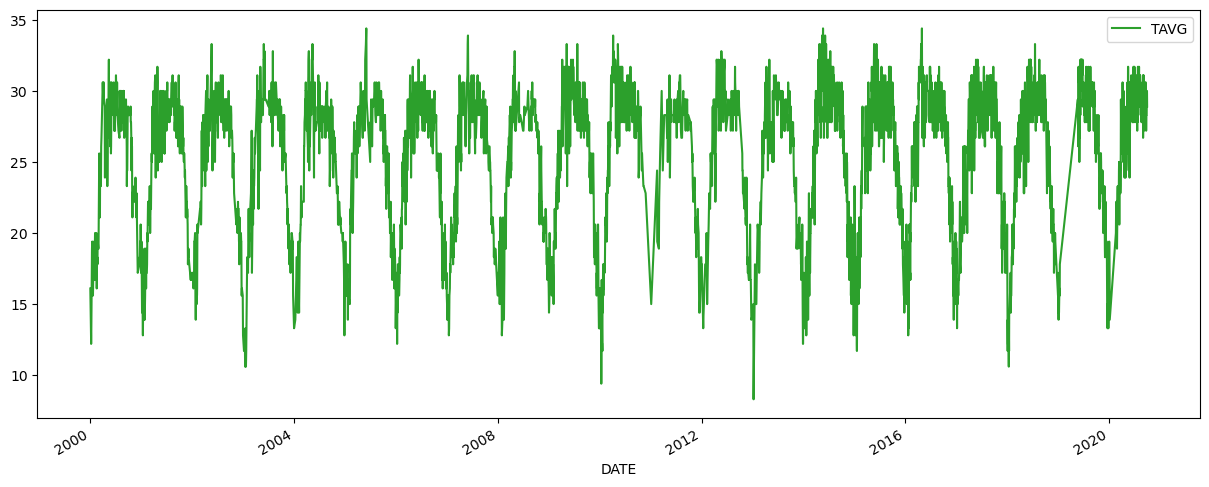

In [35]:
palette = sns.color_palette()
df.plot(color=palette[2], figsize=(15, 6))

In [36]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df.index.dayofweek
    df['weekday'] = df.index.day_name()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.strftime('%U').astype(int)
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='TAVG')
df = pd.concat([X, y], axis=1)

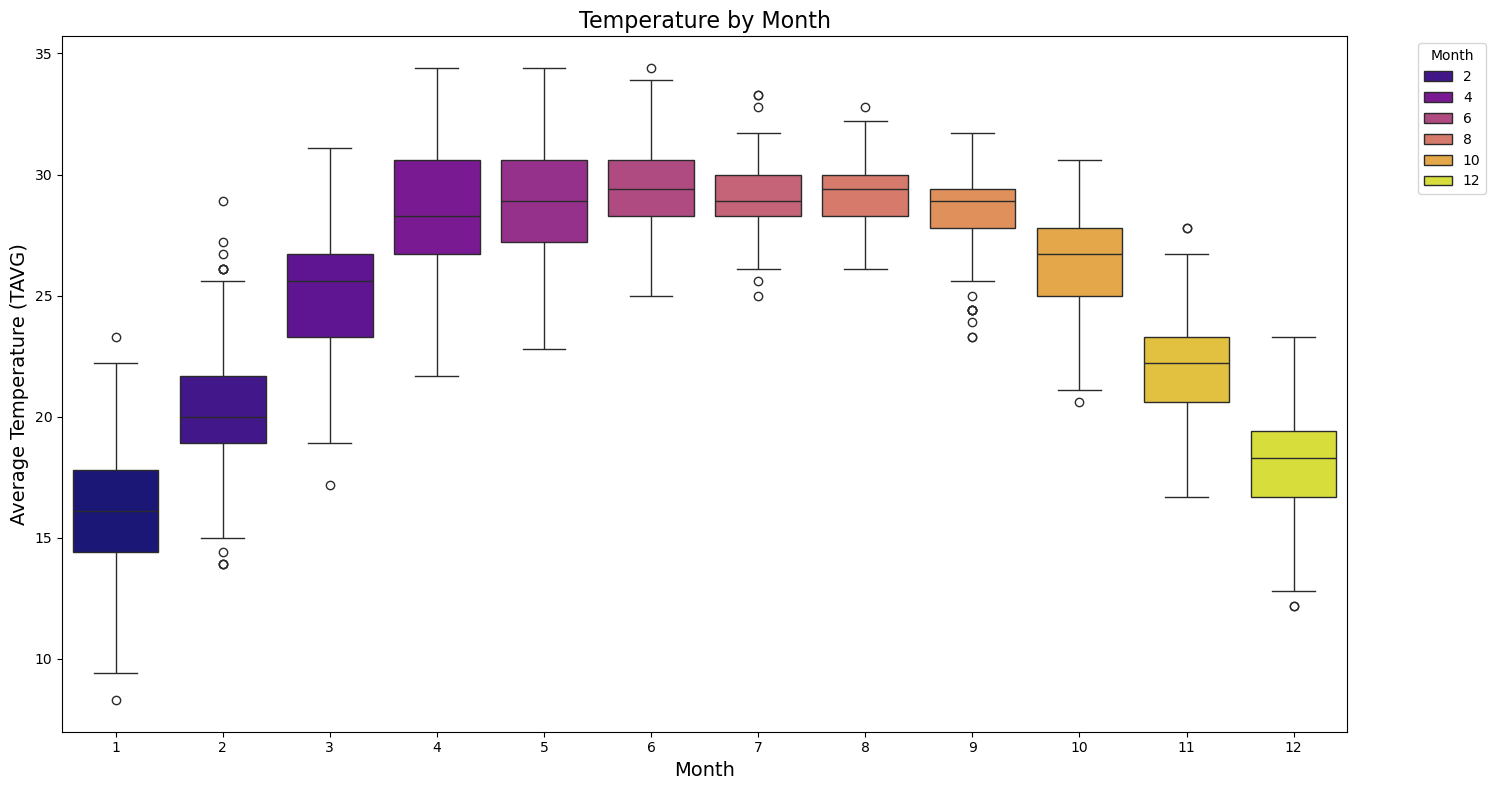

In [37]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='month', y='TAVG', palette='plasma', hue='month', ax=ax)
ax.set_title('Temperature by Month', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Average Temperature (TAVG)', fontsize=14)
ax.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

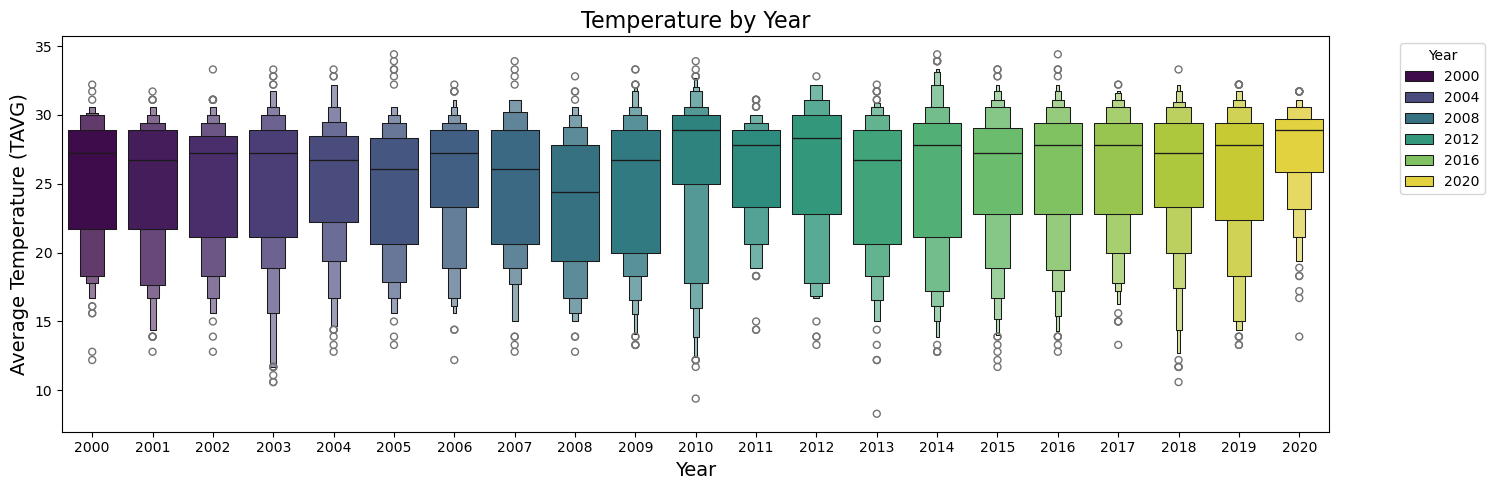

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxenplot(data=df, x='year', y='TAVG', palette='viridis', hue='year', ax=ax)
ax.set_title('Temperature by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Average Temperature (TAVG)', fontsize=14)
ax.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

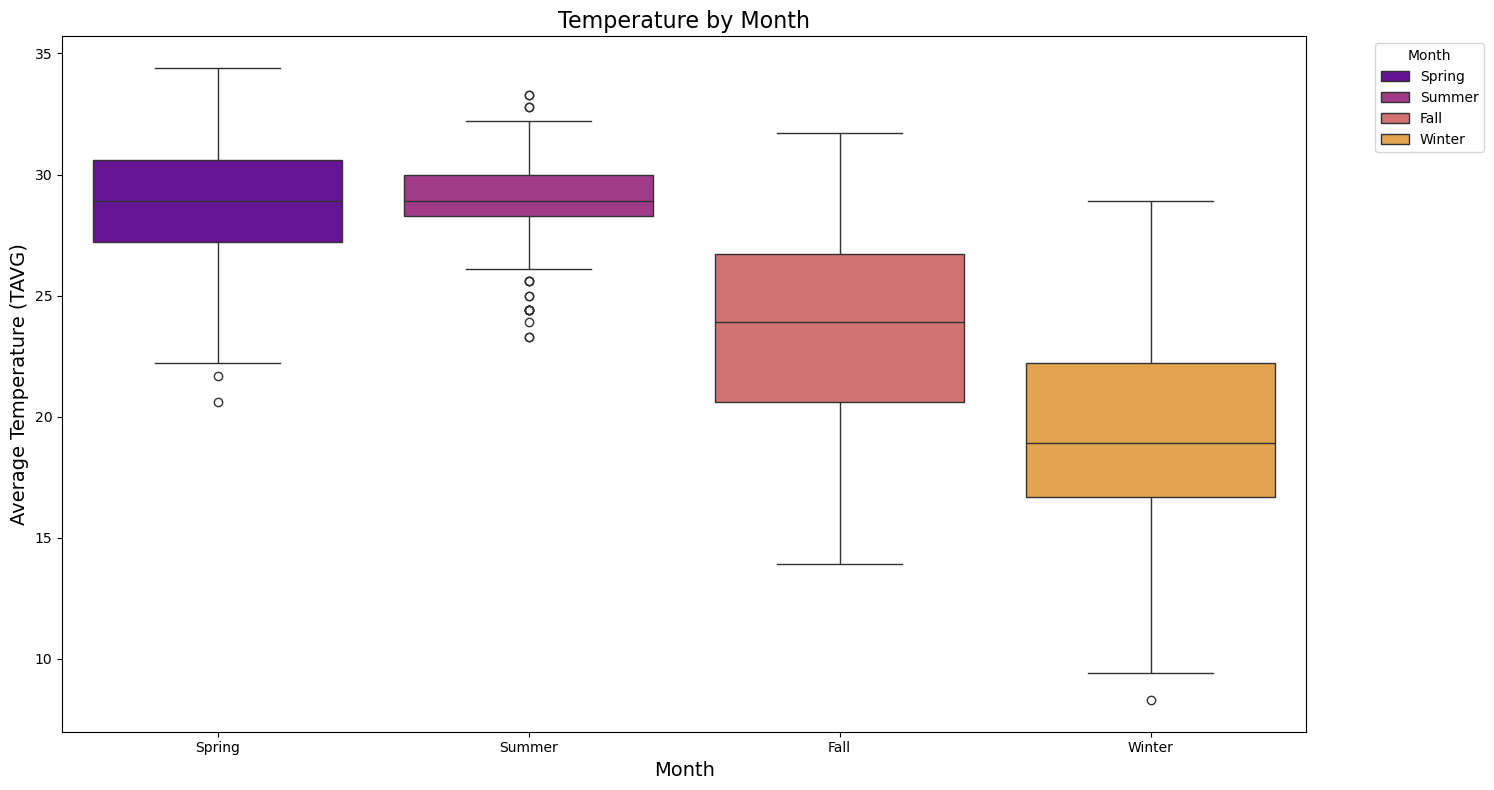

In [39]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='season', y='TAVG', palette='plasma', hue='season', ax=ax)
ax.set_title('Temperature by Month', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Average Temperature (TAVG)', fontsize=14)
ax.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

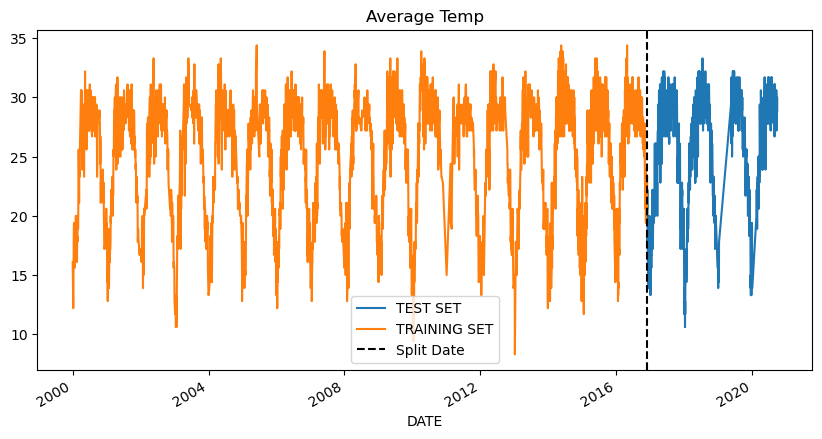

In [40]:
split_date = '1-Dec-2016'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

df_combined = df_test.rename(columns={'TAVG': 'TEST SET'}).join(
    df_train.rename(columns={'TAVG': 'TRAINING SET'}),
    how='outer',
    lsuffix='_test',
    rsuffix='_train'
)

ax = df_combined[['TEST SET', 'TRAINING SET']].plot(figsize=(10, 5), title='Average Temp', style='-', ms=1)
plt.axvline(pd.to_datetime(split_date), color='black', linestyle='--', label='Split Date')
plt.legend()
plt.show()


In [41]:
# Format data for prophet model using ds and y
df_train_prophet = df_train.reset_index().rename(columns={'DATE':'ds', 'TAVG':'y'})

In [42]:
from prophet import Prophet

model = Prophet()
model.fit(df_train_prophet)

12:31:05 - cmdstanpy - INFO - Chain [1] start processing
12:31:05 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
df_test_prophet = df_test.reset_index().rename(columns={'DATE':'ds', 'TAVG':'y'})

test_forecast = model.predict(df_test_prophet)

In [44]:
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-12-02,25.904095,17.720420,22.277905,25.904095,25.904095,-5.772988,-5.772988,-5.772988,-0.032041,-0.032041,-0.032041,-5.740947,-5.740947,-5.740947,0.0,0.0,0.0,20.131107
1,2016-12-03,25.904855,17.713132,22.426318,25.904855,25.904855,-5.823467,-5.823467,-5.823467,0.023960,0.023960,0.023960,-5.847426,-5.847426,-5.847426,0.0,0.0,0.0,20.081388
2,2016-12-06,25.907134,17.559480,22.066305,25.907134,25.907134,-6.146084,-6.146084,-6.146084,-0.001452,-0.001452,-0.001452,-6.144632,-6.144632,-6.144632,0.0,0.0,0.0,19.761050
3,2016-12-07,25.907894,17.338831,21.879322,25.907894,25.907894,-6.180202,-6.180202,-6.180202,0.057797,0.057797,0.057797,-6.237999,-6.237999,-6.237999,0.0,0.0,0.0,19.727692
4,2016-12-08,25.908653,17.356532,21.792385,25.908653,25.908653,-6.348342,-6.348342,-6.348342,-0.018876,-0.018876,-0.018876,-6.329466,-6.329466,-6.329466,0.0,0.0,0.0,19.560311


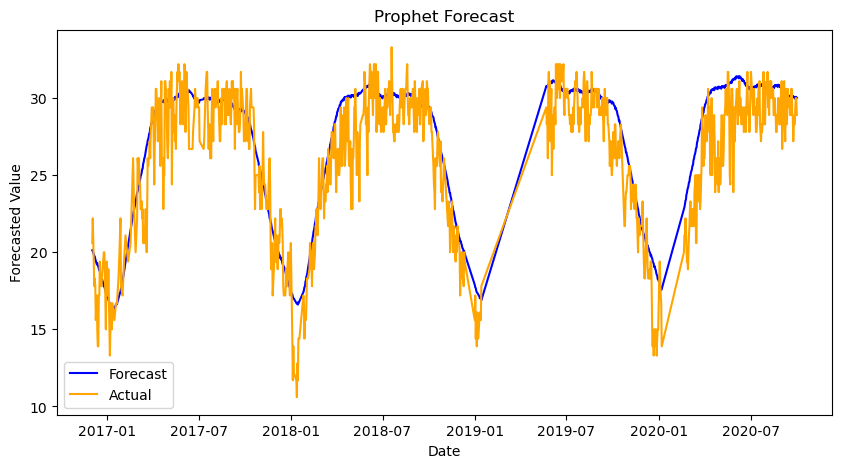

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test_forecast['ds'], test_forecast['yhat'], label='Forecast', color='blue')

ax.plot(test_forecast['ds'], df_test_prophet['y'], label='Actual', color='orange')
ax.set_title('Prophet Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Forecasted Value')
ax.legend()

plt.show()


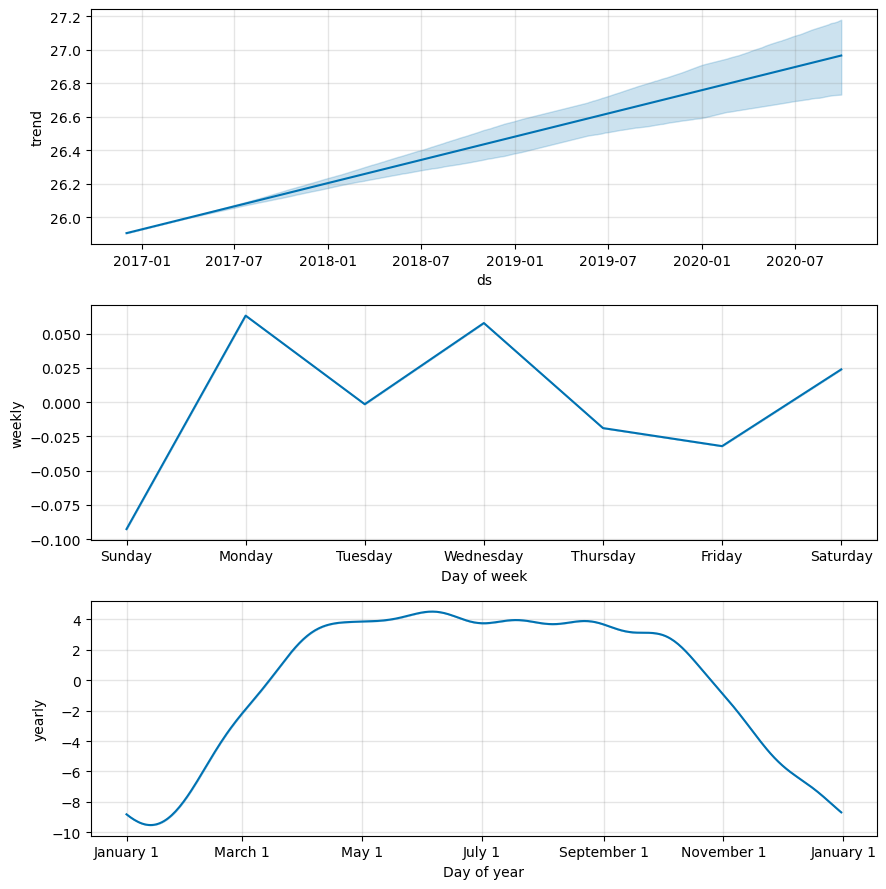

In [46]:
fig = model.plot_components(test_forecast)
plt.show()

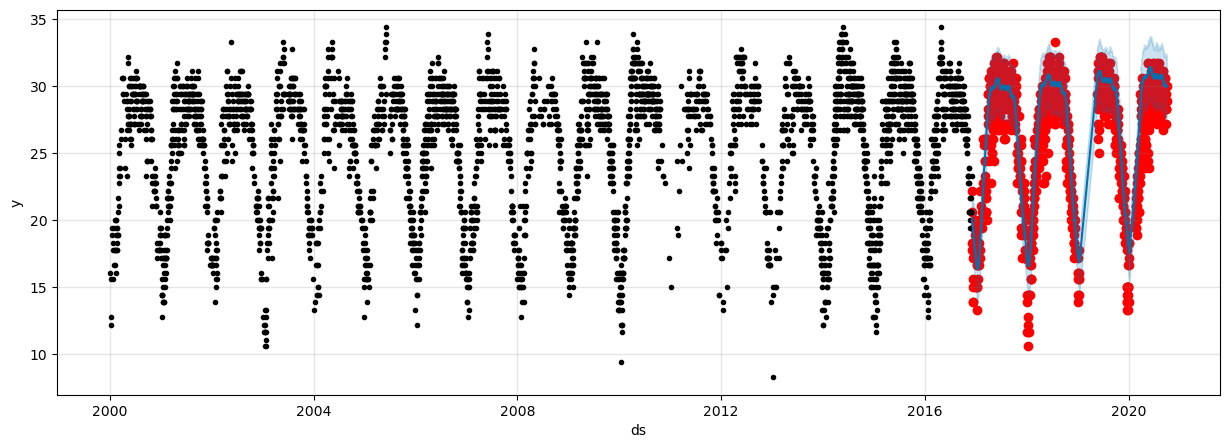

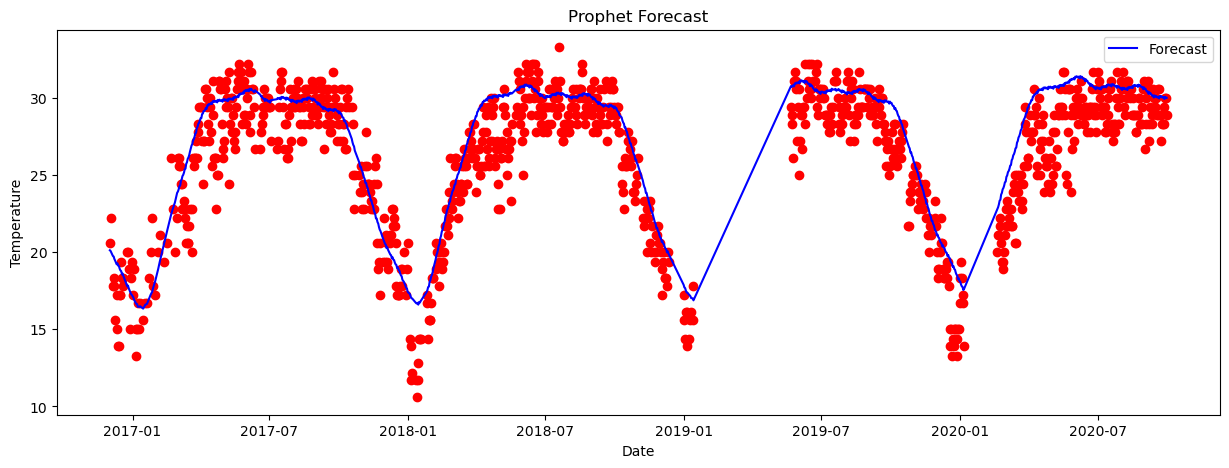

In [47]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['TAVG'], color='red')
fig = model.plot(test_forecast, ax=ax)

f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['TAVG'], color='red')
ax.plot(test_forecast['ds'], test_forecast['yhat'], label='Forecast', color='blue')
ax.set_title('Prophet Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()


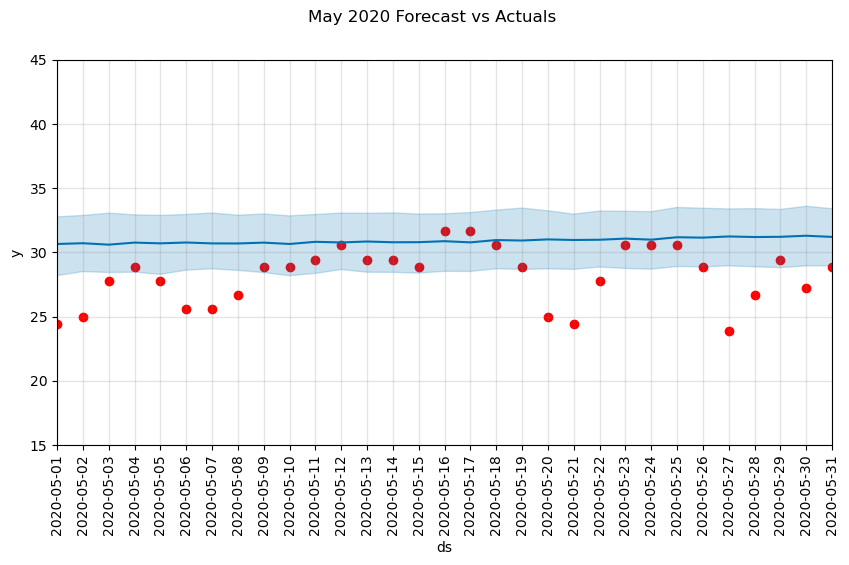

In [48]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_test.index, df_test['TAVG'], color='r')
model.plot(test_forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2020-5-1'), upper=pd.to_datetime('2020-5-31'))
ax.set_ylim(15, 45)
plt.suptitle('May 2020 Forecast vs Actuals')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=90)

plt.show()


In [49]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [50]:
np.sqrt(mean_squared_error(y_true=df_test['TAVG'],
                   y_pred=test_forecast['yhat']))

2.237125877161714

In [51]:
mean_absolute_error(y_true=df_test['TAVG'],
                   y_pred=test_forecast['yhat'])

1.72119288626758

In [52]:
mean_absolute_percentage_error(y_true=df_test['TAVG'],
                   y_pred=test_forecast['yhat'])

0.07313505751796336

[I 2025-03-29 12:31:07,818] A new study created in memory with name: no-name-03a85a78-a008-44ed-9cb3-9c984260593f
12:31:08 - cmdstanpy - INFO - Chain [1] start processing
12:31:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-29 12:31:09,089] Trial 0 finished with value: 10.762013797183325 and parameters: {'changepoint_prior_scale': 0.4716938433992038, 'seasonality_prior_scale': 8.117367774480986, 'seasonality_mode': 'multiplicative', 'n_changepoints': 11}. Best is trial 0 with value: 10.762013797183325.
12:31:09 - cmdstanpy - INFO - Chain [1] start processing
12:31:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-29 12:31:11,927] Trial 1 finished with value: 10.742942016200187 and parameters: {'changepoint_prior_scale': 0.17482718154139873, 'seasonality_prior_scale': 2.3045783725150524, 'seasonality_mode': 'multiplicative', 'n_changepoints': 83}. Best is trial 1 with value: 10.742942016200187.
12:31:12 - cmdstanpy - INFO - Chain [1] start processing
12:31:12 - 

Best hyperparameters:  {'changepoint_prior_scale': 0.1327521305372028, 'seasonality_prior_scale': 0.010787328903807486, 'seasonality_mode': 'additive', 'n_changepoints': 73}
Best MAE:  10.291626700423823


12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:06 - cmdstanpy - INFO - Chain [1] done processing


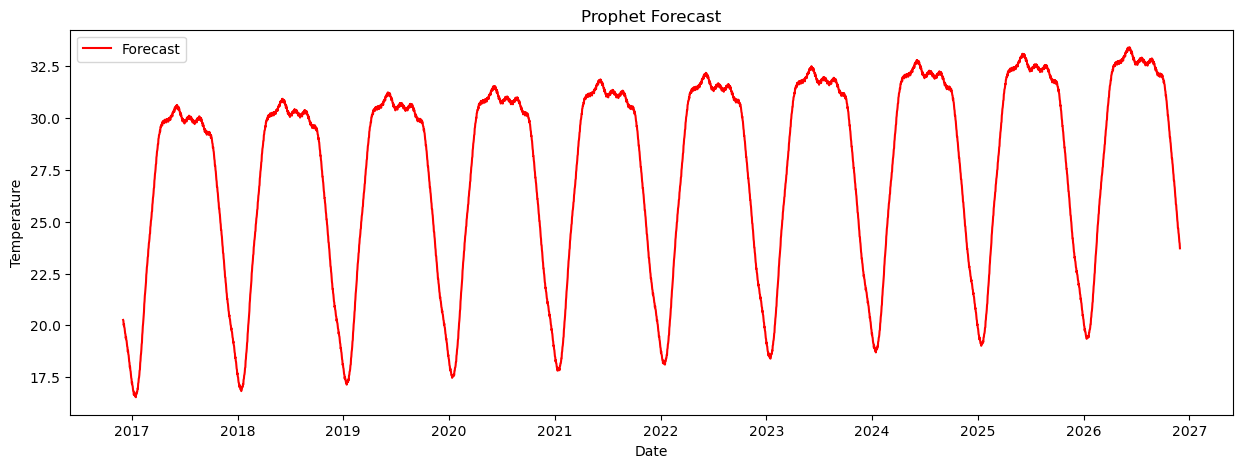

In [53]:
import pandas as pd
from prophet import Prophet
import optuna
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

full_train = df_train_prophet

def objective(trial):
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10.0)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    n_changepoints = trial.suggest_int('n_changepoints', 5, 100)

    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
        n_changepoints=n_changepoints
    )
    
    model.fit(full_train)
    periods = 30
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    y_true = df_test_prophet['y'][-periods:].values
    y_pred = forecast['yhat'][-periods:].values

    if len(y_true) != len(y_pred):
        raise ValueError(f"Length mismatch: y_true has {len(y_true)} samples, y_pred has {len(y_pred)} samples.")

    mae = mean_absolute_error(y_true, y_pred)

    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters: ", study.best_params)
print("Best MAE: ", study.best_value)

best_params = study.best_params
best_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    n_changepoints=best_params['n_changepoints']
)

best_model.fit(full_train)

future = best_model.make_future_dataframe(periods=365*10, freq='d', include_history=False)
forecast = best_model.predict(future)

f, ax = plt.subplots(figsize=(15, 5))
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
ax.set_title('Prophet Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()


In [ ]:
# full_train = df.reset_index() \
#     .rename(columns={'DATE':'ds',
#                      'TAVG':'y'})

# future_model = Prophet()
# future_model.fit(full_train)

12:33:08 - cmdstanpy - INFO - Chain [1] start processing
12:33:10 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# future = future_model.make_future_dataframe(periods=365*10, freq='d', include_history=False)

In [ ]:
# forecast = future_model.predict(future)

In [ ]:
# forecast[['ds','yhat']].head()

,ds,yhat
0,2020-10-01,27.918688
1,2020-10-02,27.875139
2,2020-10-03,27.864832
3,2020-10-04,27.679644
4,2020-10-05,27.716137


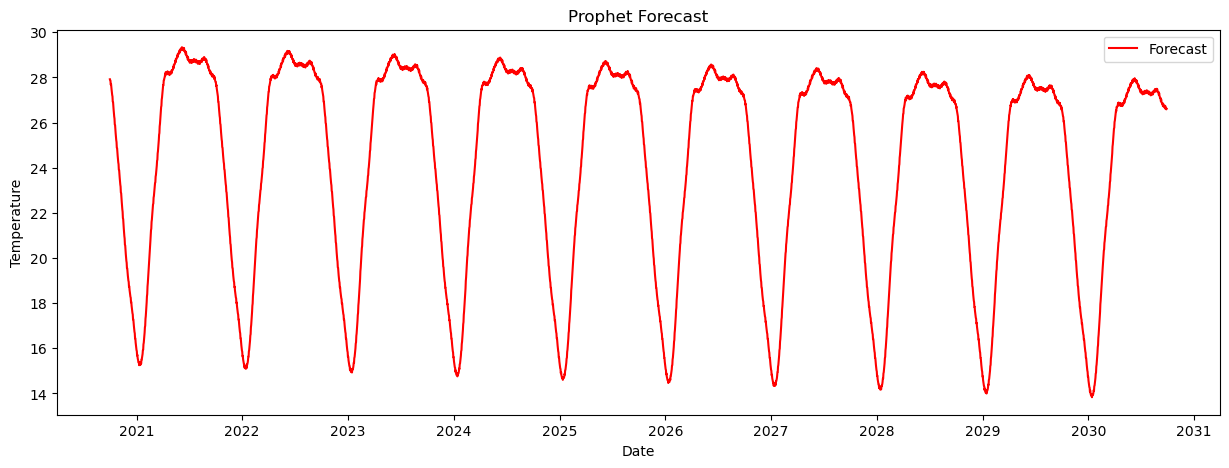

In [ ]:
# f, ax = plt.subplots(figsize=(15, 5))
# ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
# ax.set_title('Prophet Forecast')
# ax.set_xlabel('Date')
# ax.set_ylabel('Temperature')
# ax.legend()
# plt.show()

In [59]:
# import joblib

# joblib.dump(best_model, 'AVG_TEMP.pkl')